In [2]:
import warnings

import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pprint
pp = pprint.PrettyPrinter(indent=4)

pd.set_option("display.precision", 2)
warnings.filterwarnings("ignore")

# some imports to set up plotting
import matplotlib.pyplot as plt
import matplotlib.ticker
%matplotlib inline
# !pip install seaborn
import seaborn as sns

# import some nice vis settings
sns.set()
# Graphics in the Retina format are more sharp and legible
%config InlineBackend.figure_format = 'retina'

# Tune the visual settings for figures in `seaborn`
sns.set_context(
    "notebook", font_scale=1.5, rc={"figure.figsize": (11, 8), "axes.titlesize": 18}
)

from matplotlib import rcParams

rcParams["figure.figsize"] = 11, 8



In [3]:
DATA_URL = "./data/"
df = pd.read_csv(DATA_URL + "cardiovascular.csv", sep=";")
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [4]:
df.shape

(70000, 13)

Convert the data into long format

In [5]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active", "cardio"],
)

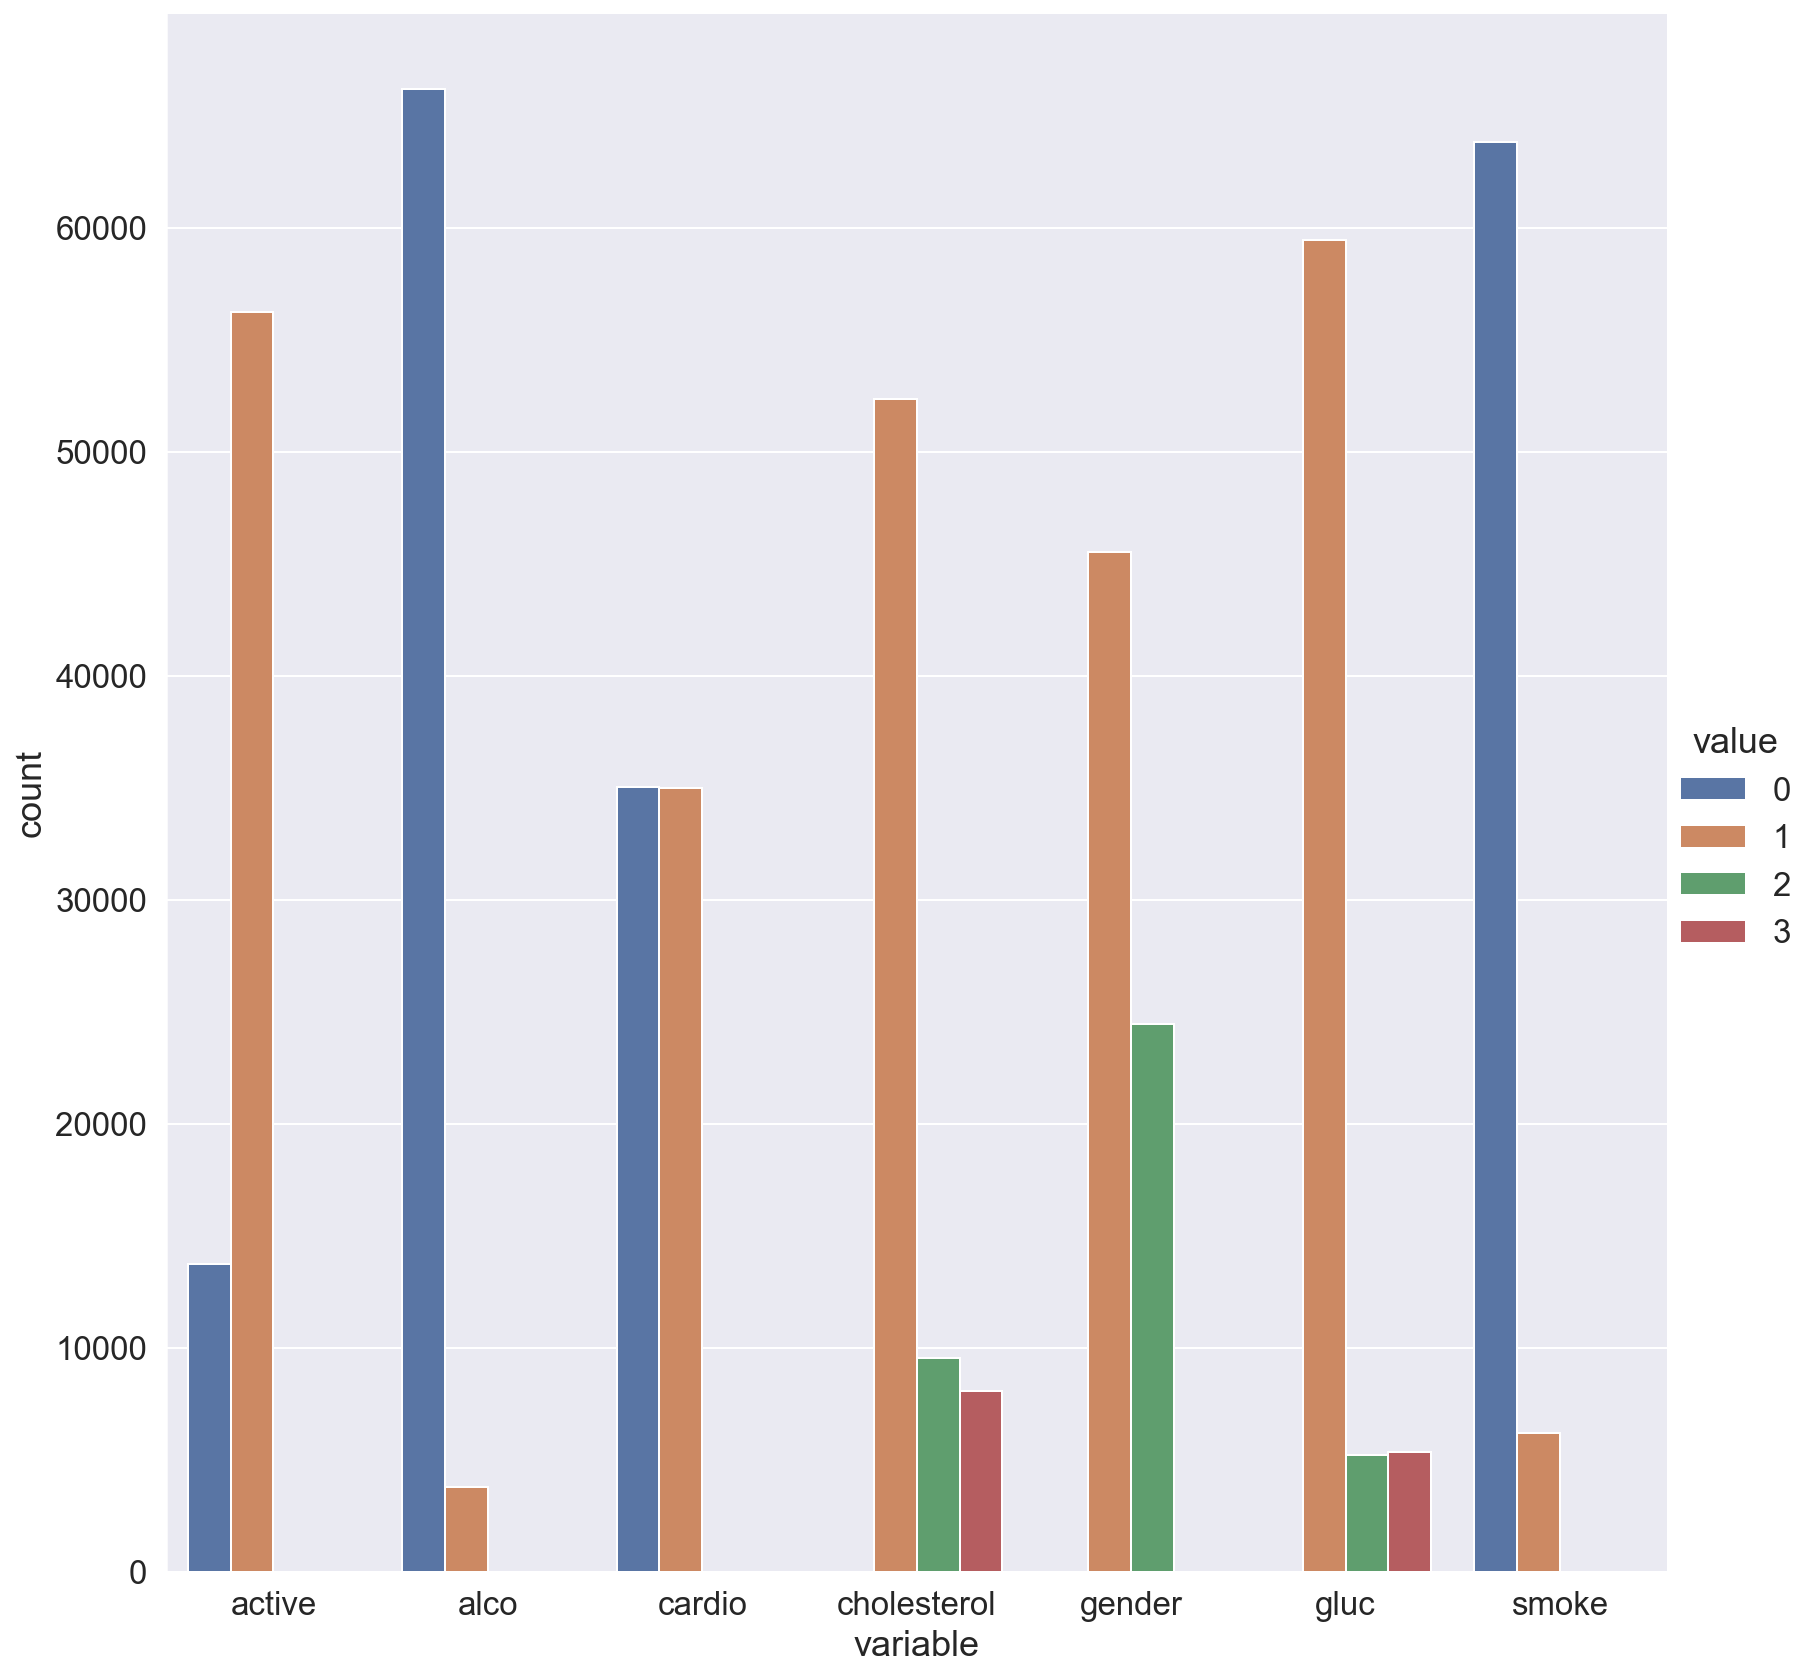

In [6]:
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.factorplot(
    x="variable", y="count", hue="value", data=df_uniques, kind="bar", size=12
);

 The target classes are balanced. 

 Split the dataset by target values

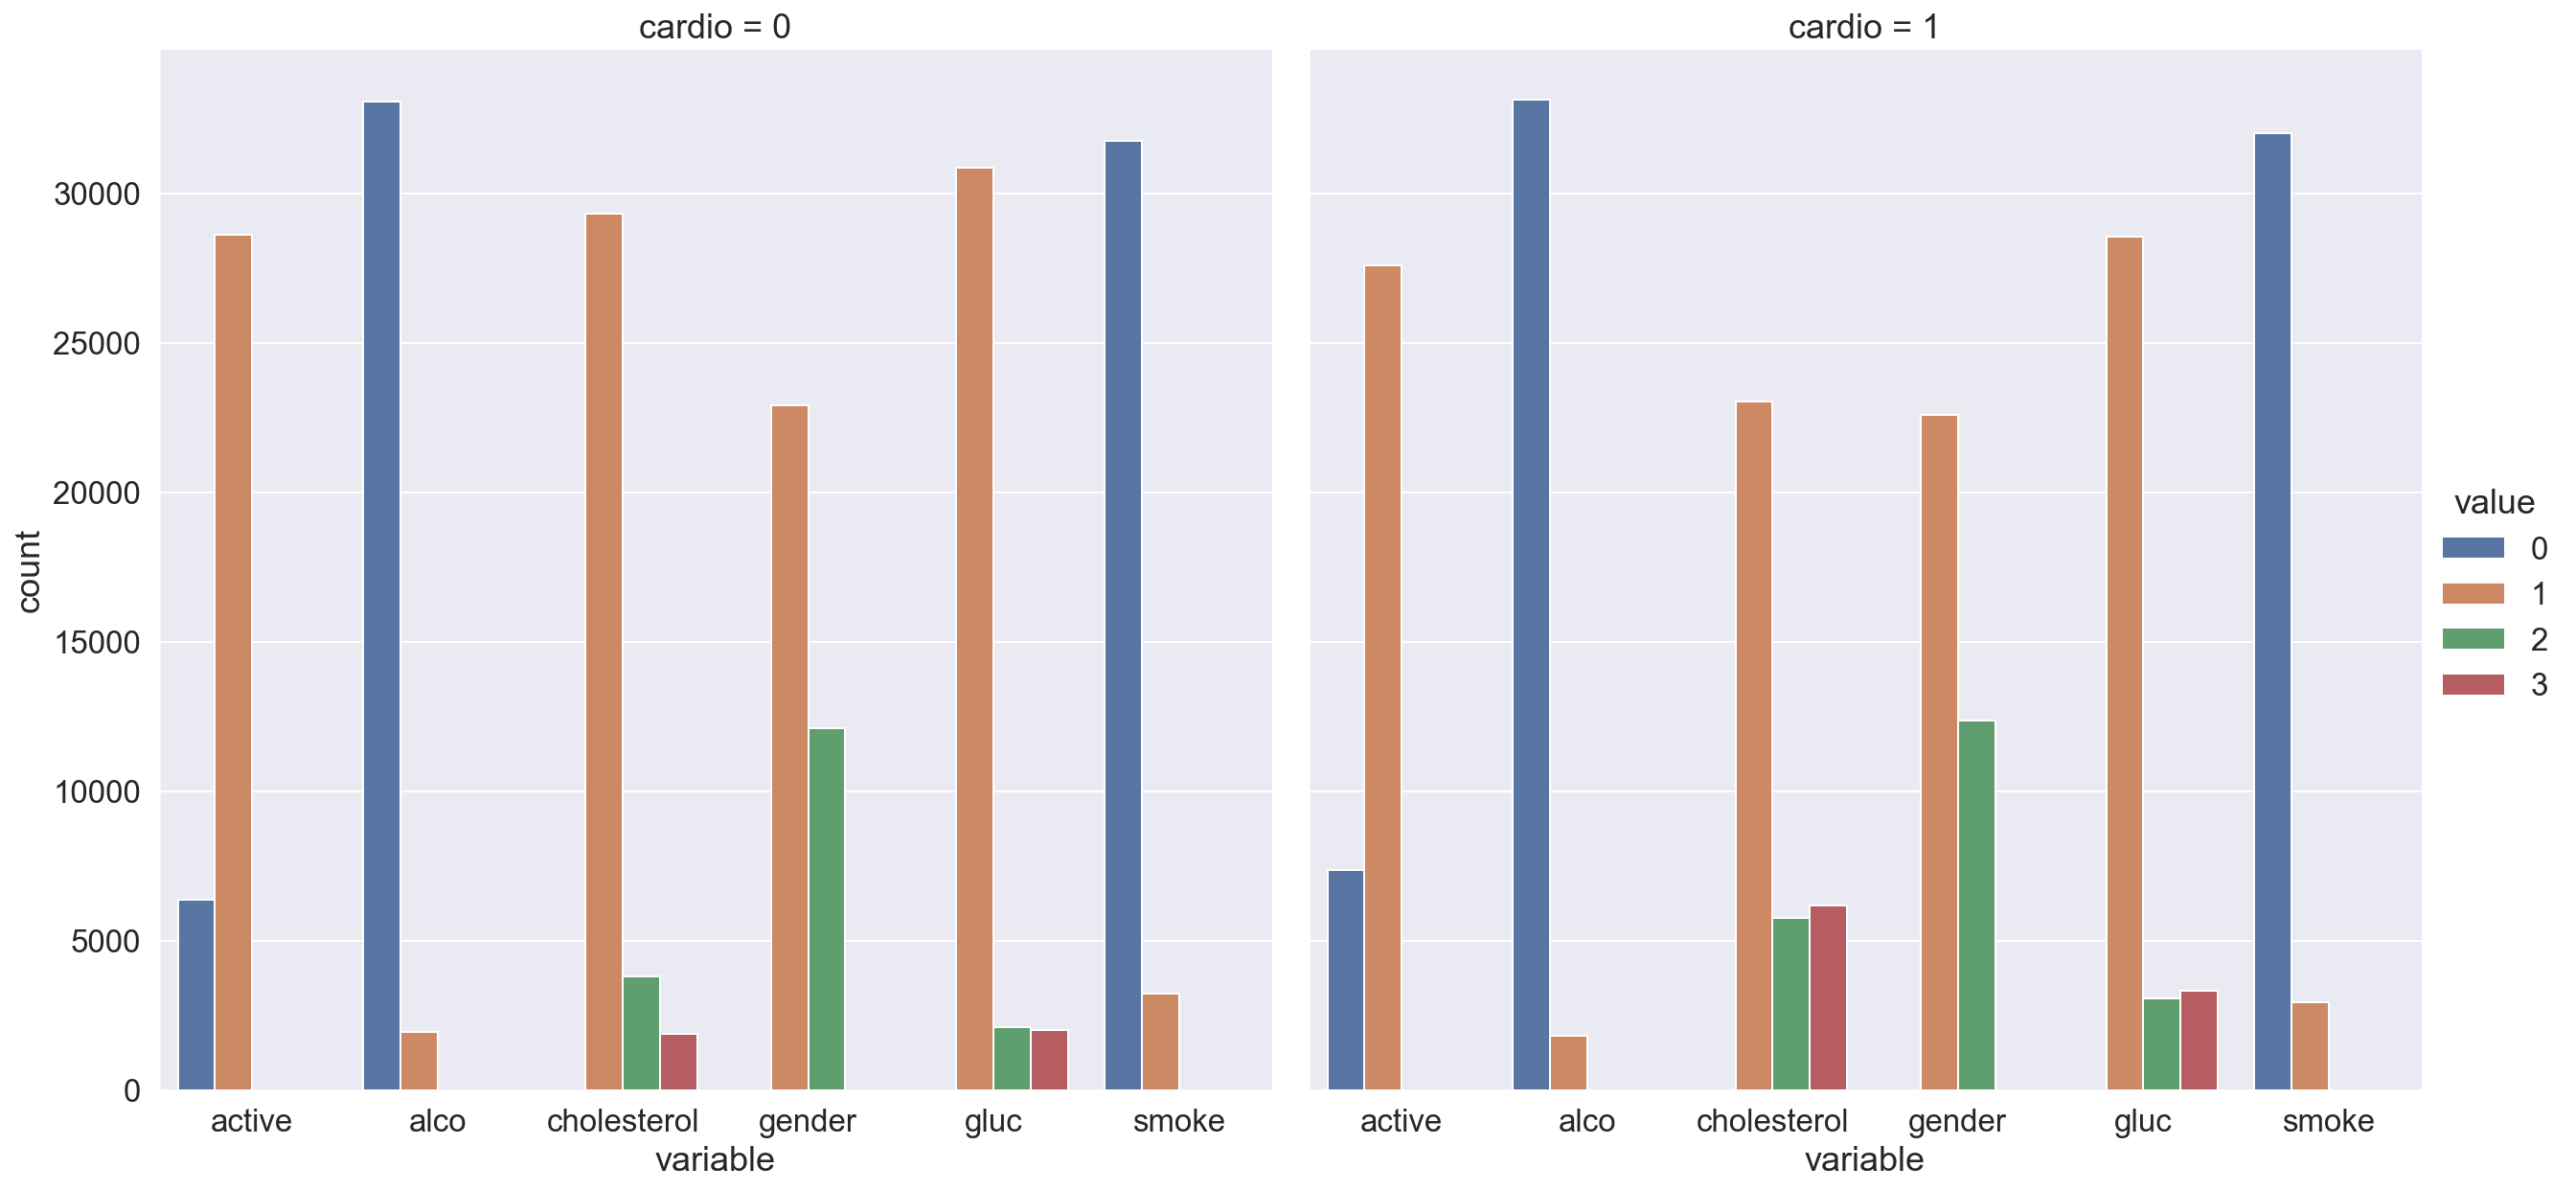

In [7]:
df_uniques = pd.melt(
    frame=df,
    value_vars=["gender", "cholesterol", "gluc", "smoke", "alco", "active"],
    id_vars=["cardio"],
)
df_uniques = (
    pd.DataFrame(df_uniques.groupby(["variable", "value", "cardio"])["value"].count())
    .sort_index(level=[0, 1])
    .rename(columns={"value": "count"})
    .reset_index()
)

sns.factorplot(
    x="variable",
    y="count",
    hue="value",
    col="cardio",
    data=df_uniques,
    kind="bar",
    size=9,
);

 Distribution of cholesterol and glucose levels great differs by the value of the target variable

In [8]:
for c in df.columns:
    n = df[c].nunique()
    print(c)
    if n <= 3:
        print(n, sorted(df[c].value_counts().to_dict().items()))
    else:
        print(n)
    print(10 * "-")

id
70000
----------
age
8076
----------
gender
2 [(1, 45530), (2, 24470)]
----------
height
109
----------
weight
287
----------
ap_hi
153
----------
ap_lo
157
----------
cholesterol
3 [(1, 52385), (2, 9549), (3, 8066)]
----------
gluc
3 [(1, 59479), (2, 5190), (3, 5331)]
----------
smoke
2 [(0, 63831), (1, 6169)]
----------
alco
2 [(0, 66236), (1, 3764)]
----------
active
2 [(0, 13739), (1, 56261)]
----------
cardio
2 [(0, 35021), (1, 34979)]
----------


* 5 numerical features (excluding id);
* 7 categorical features;
* 70000 records in total.

How many men and women are present in this dataset? Values of the gender feature were not given (whether “1” stands for women or for men) – figure this out by looking analyzing height, making the assumption that men are taller on average.

In [9]:
df["gender"].value_counts()

1    45530
2    24470
Name: gender, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

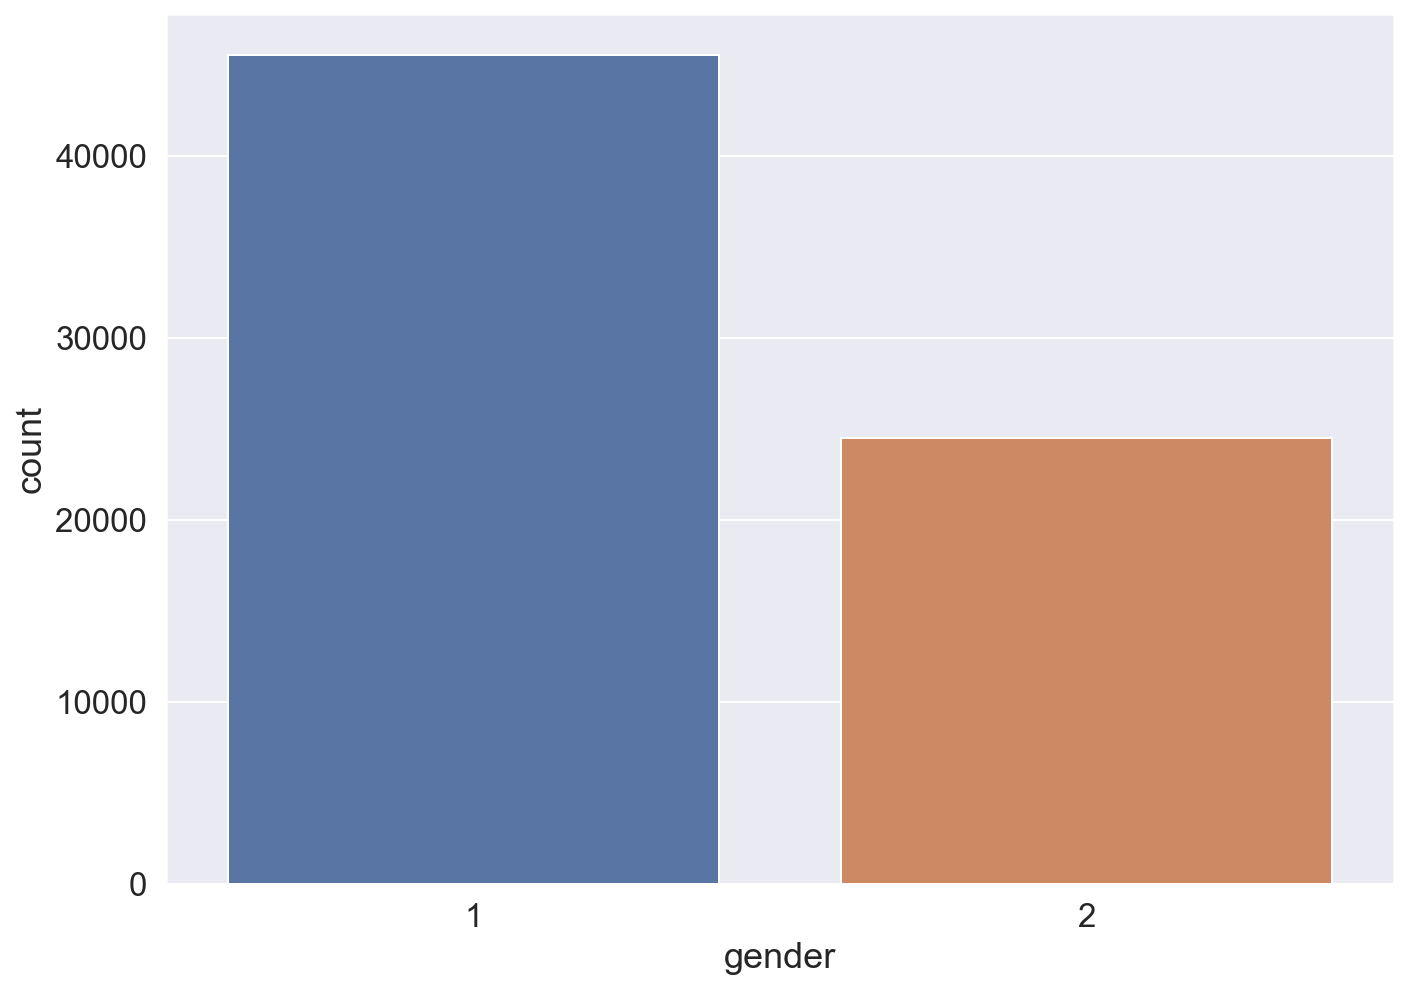

In [10]:
sns.countplot(x="gender", data=df)

In [11]:
df.groupby(["gender"])["height"].agg([np.mean, np.count_nonzero])

,mean,count_nonzero
gender,,
1,161.36,45530
2,169.95,24470


* gender=1 represents females, and gender=2 – males
* Sample contains 45530 women and 24470 men

Who more often report consuming alcohol – men or women?

In [12]:
pd.crosstab(df["gender"], df["alco"])

alco,0,1
gender,,
1,44369,1161
2,21867,2603


In [13]:
df.groupby("gender")["alco"].mean()

gender
1    0.03
2    0.11
Name: alco, dtype: float64

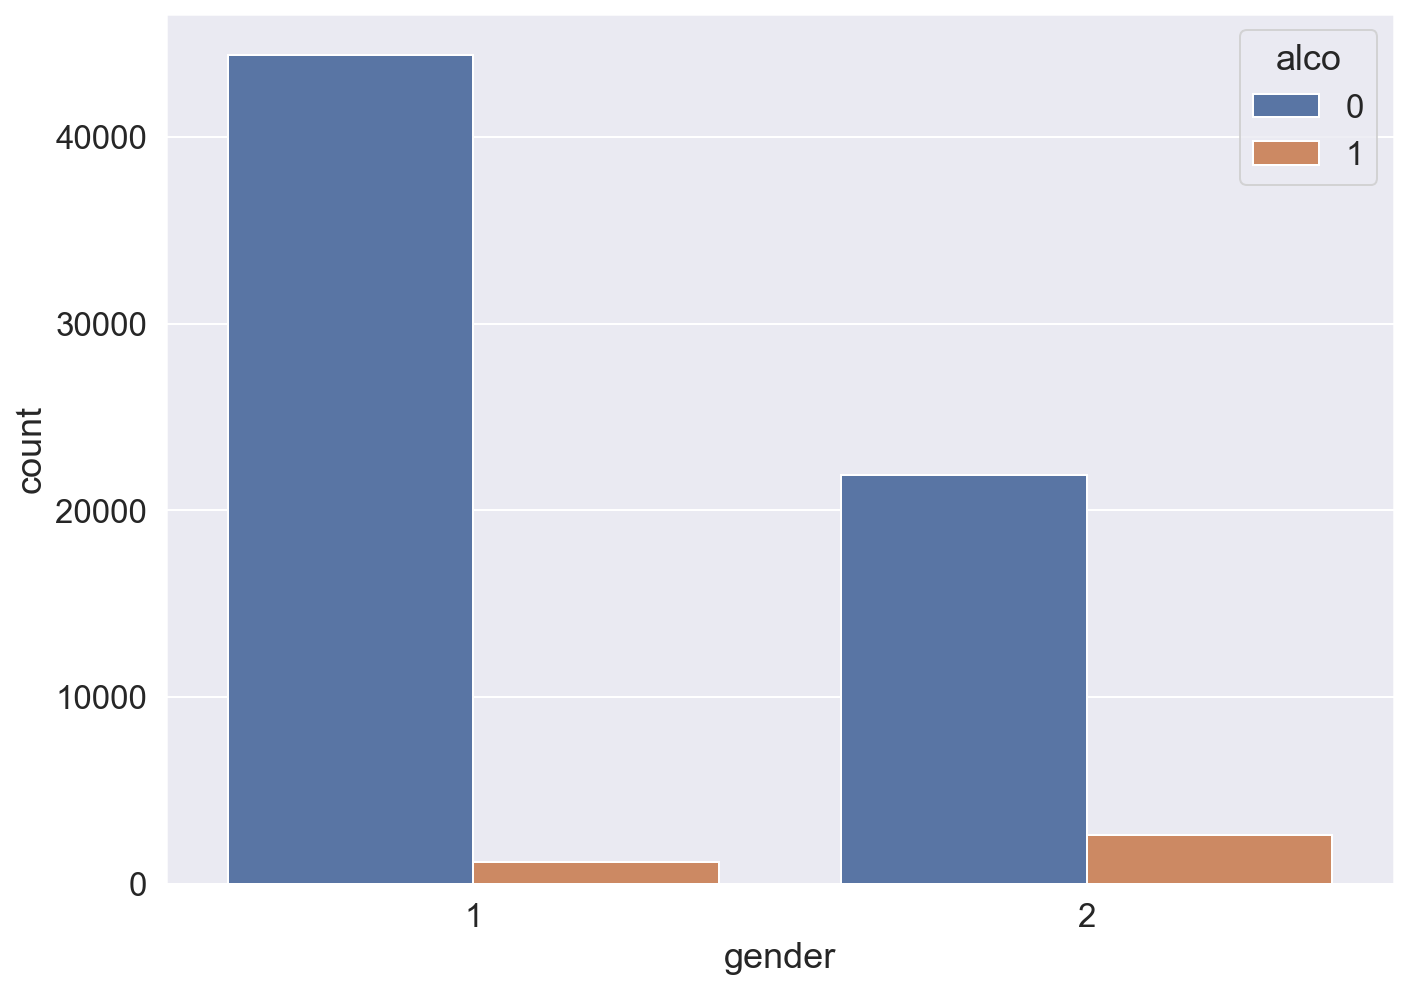

In [14]:
sns.countplot(x="gender", 
                hue="alco", 
                data=df);

Obvious: Men consume more alcohol!

What’s the rounded difference between the percentages of smokers among men and women?

In [15]:
df.groupby(["gender"])['smoke'].value_counts(normalize=True)

gender  smoke
1       0        0.98
        1        0.02
2       0        0.78
        1        0.22
Name: smoke, dtype: float64

20% - rounded difference between the percentages

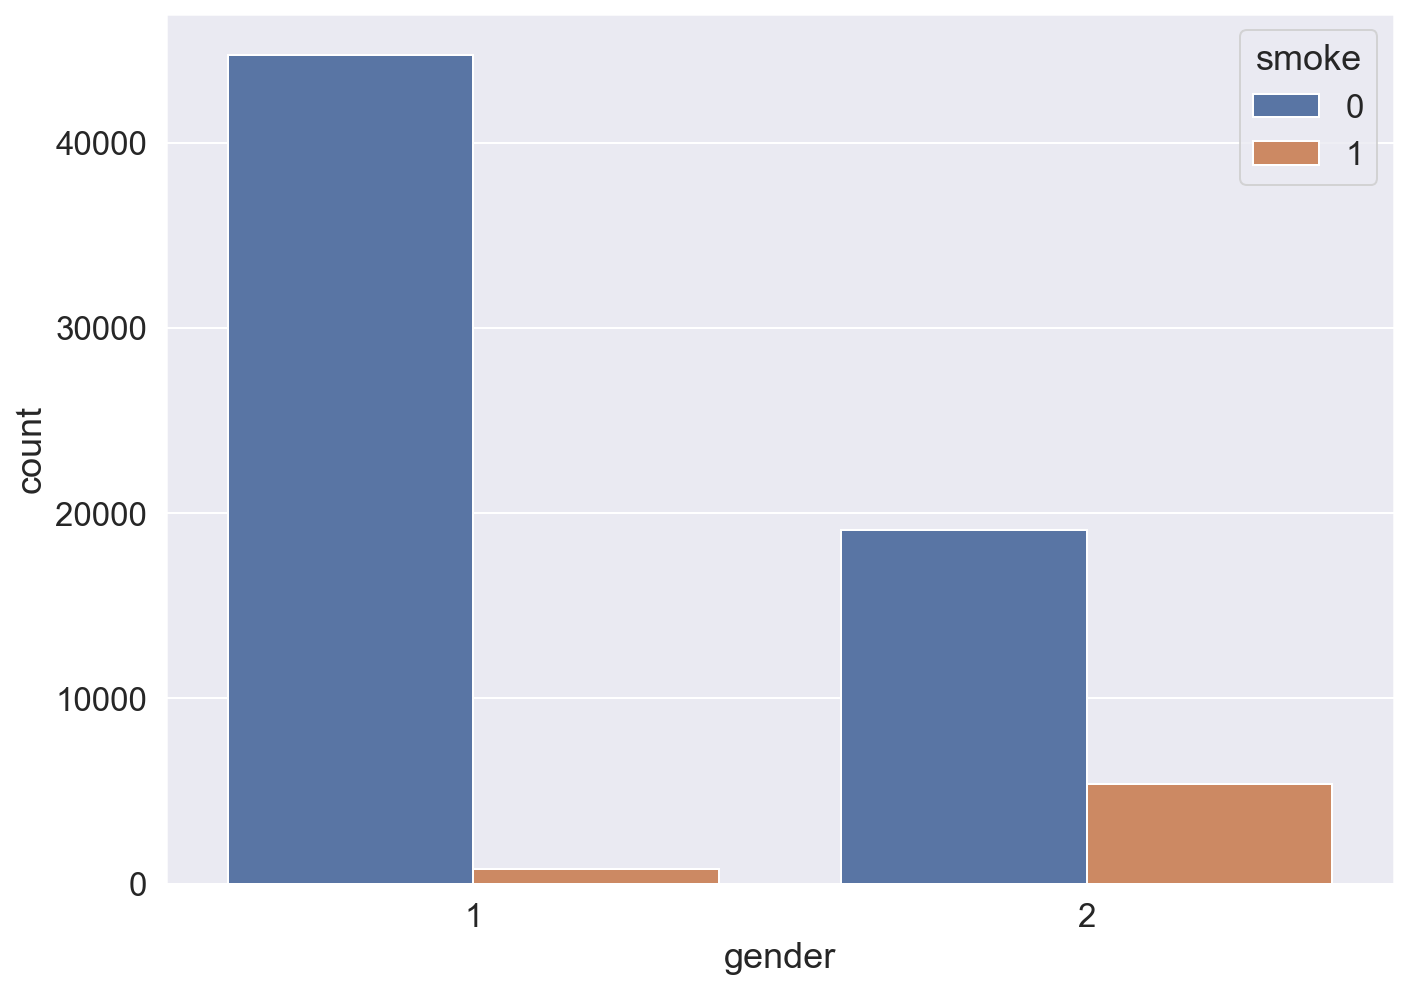

In [16]:
sns.countplot(x="gender", 
                hue="smoke", 
                data=df);

What’s the rounded difference between median values of age (in months) for non-smokers and smokers? You’ll need to figure out the units of feature age in this dataset.

In [17]:
df.groupby(["smoke"])["age"].median() / 31

smoke
0    636.19
1    616.94
Name: age, dtype: float64

Answer is 20 months

Smoking men aged from 60 to 65 — for people in this gender-age group whose systolic pressure is less than 120, the risk of a CVD is estimated to be 5 times lower than for those with the pressure in the interval [160,180)

How to verify that using our data?

* Calculate age_years feature – round age to the nearest number of years. For this task, select only the people of age 60 to 64, inclusive.

In [18]:
# df["age_years"] = df["age"] / 365.25
df["age_years"] = (df["age"] / 365.25).round().astype("int")
df["age_years"].head(10)

0    50
1    55
2    52
3    48
4    48
5    60
6    61
7    62
8    48
9    54
Name: age_years, dtype: int64

In [19]:
df["age_years"].max()

65

In [20]:
smoking_old_men = df[
    (df["gender"] == 2)
    & (df["age_years"] >= 60)
    & (df["age_years"] < 65)
    & (df["smoke"] == 1)
]

If cholesterol level in this age group is 1, and systolic pressure is below 120, then the proportion of people with CVD:

In [21]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 1) & (smoking_old_men["ap_hi"] < 120)
]["cardio"].mean()

0.2631578947368421

26%

If, however, cholesterol level in this age group is 3, and systolic pressure is from 160 to 180, then the proportion of people with a CVD:

In [22]:
smoking_old_men[
    (smoking_old_men["cholesterol"] == 3)
    & (smoking_old_men["ap_hi"] >= 160)
    & (smoking_old_men["ap_hi"] < 180)
]["cardio"].mean()

0.8636363636363636

86%

Calculate fractions of ill people (with CVD) in the two groups of people described in the task. What’s the ratio of these two fractions?

In [23]:
0.86/0.26

3.3076923076923075

#### Analyzing BMI

Divide weight in kilograms by the square of the height in meters. Normal BMI values are said to be from 18.5 to 25.

In [24]:
df["bmi"] = df["weight"] / (df["height"]*0.01) ** 2

df["bmi"].head()

0    21.97
1    34.93
2    23.51
3    28.71
4    23.01
Name: bmi, dtype: float64

Median BMI in the sample is within boundaries of normal values??

In [25]:
df["bmi"].median()

26.374068120774975

Median BMI exceeds the norm of 25 points.

Women’s BMI is on average higher then men’s??

In [26]:
df.groupby("gender")["bmi"].median()

gender
1    26.71
2    25.91
Name: bmi, dtype: float64

Women’s BMI is higher on average.

Healthy people have higher median BMI than ill people??

In [27]:
df.groupby(["cardio"])["bmi"].median()

cardio
0    25.48
1    27.47
Name: bmi, dtype: float64

The above statement — Healthy people have higher median BMI than ill people — is incorrect.

In the segment of healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women??


In [28]:
df.groupby(["gender", "alco", "cardio"])["bmi"].median()

gender  alco  cardio
1       0     0         25.65
              1         27.89
        1     0         27.89
              1         30.11
2       0     0         25.10
              1         26.67
        1     0         25.35
              1         27.53
Name: bmi, dtype: float64

In [29]:
df.groupby(["gender", "alco", "cardio"])["bmi"].median().to_frame()

bmi
gender alco cardio       
1      0    0       25.65
            1       27.89
       1    0       27.89
            1       30.11
2      0    0       25.10
            1       26.67
       1    0       25.35
            1       27.53

Comparing BMI values in rows where alco=0 and cardio=0, we see that — healthy and non-drinking men BMI is closer to the norm than in the segment of healthy and non-drinking women.

#### Cleaning data

Data contains “dirt” and inaccuracies.

Patient Segments - erroneous data

* diastolic pressure is higher than systolic

In [30]:
err_bp = (df["ap_lo"] > df["ap_hi"]).sum()
err_bp

1234

In [31]:
df_to_remove = df[
    (df["ap_lo"] > df["ap_hi"])
    | (df["height"] < df["height"].quantile(0.025))
    | (df["height"] > df["height"].quantile(0.975))
    | (df["weight"] < df["weight"].quantile(0.025))
    | (df["weight"] > df["weight"].quantile(0.975))
]

print(df_to_remove.shape[0] / df.shape[0])

0.0963


In [32]:
filtered_df = df[~df.index.isin(df_to_remove)]

#### Correlation matrix visualization

Plot a correlation matrix using heatmap()

Which pair of features has the strongest Pearson’s correlation with the gender feature?

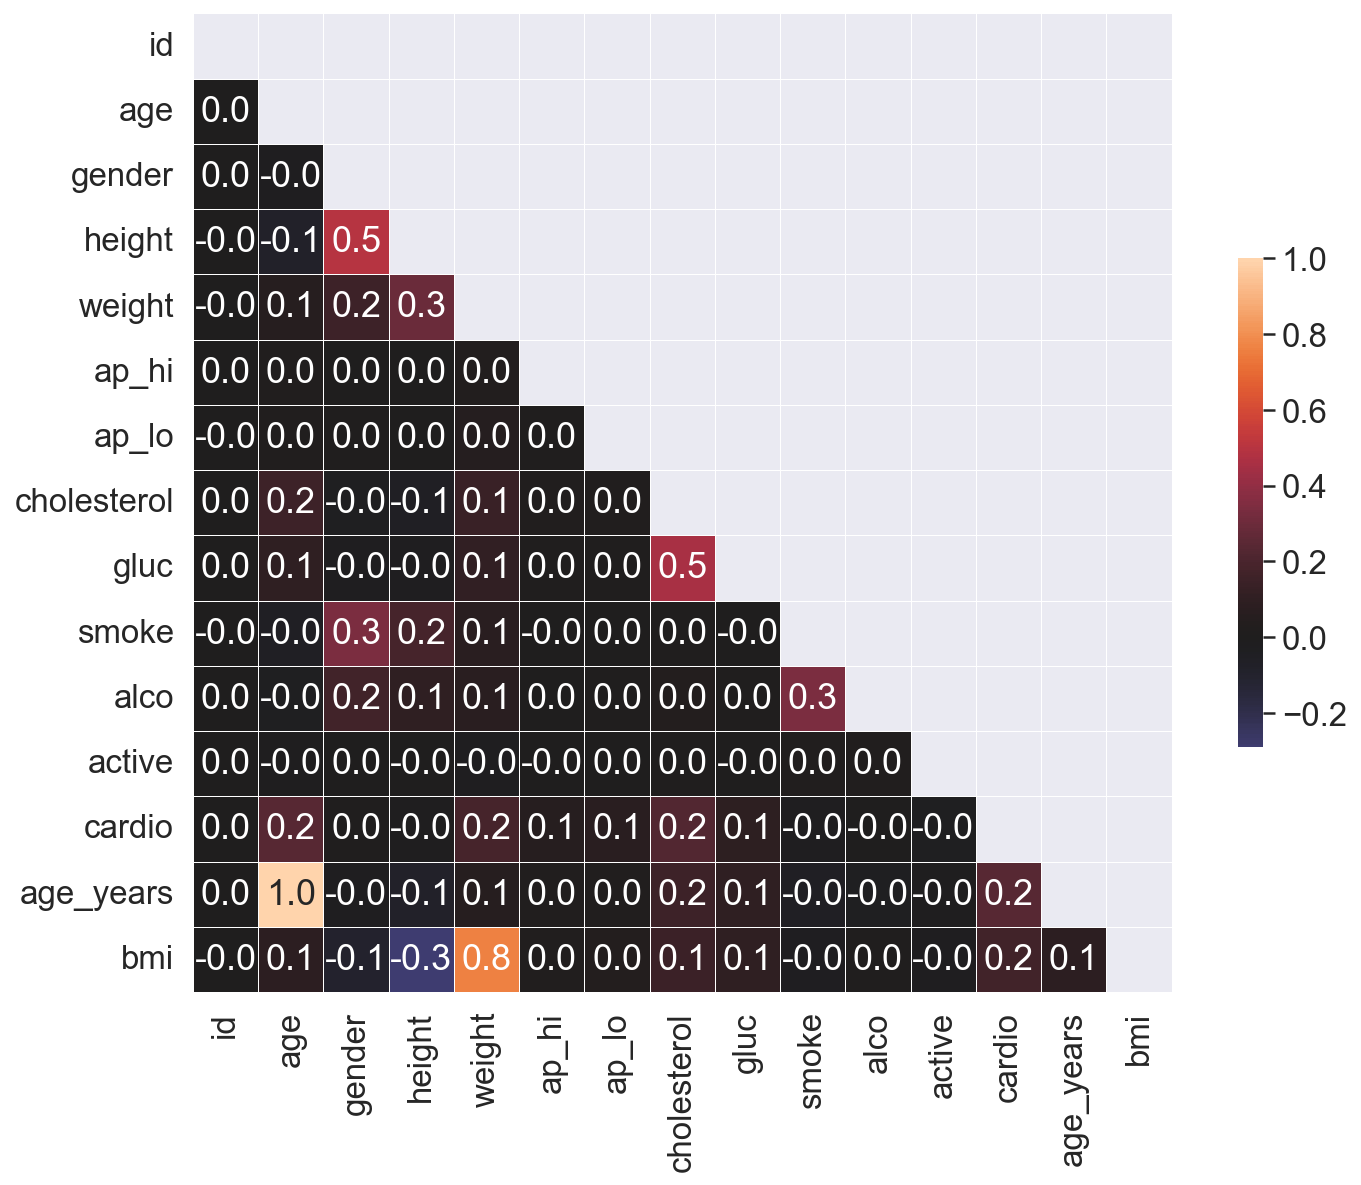

In [33]:
# Calculate the correlation matrix
df = filtered_df.copy()

corr = df.corr(method="pearson")

# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".1f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

In [ ]:
# Cardio, Cholesterol
(0.0, -0.0)
# Height, Smoke
(0.5, 0.3)
# Smoke, Alco
(0.3, 0.2)
# Height, Weight
(0.5, 0.2)

Height & Smoke has the strongest Pearson’s correlation with the gender feature.

Create a violin plot for the height and gender using violinplot(). Use the parameters:

* hue to split by gender;
* scale to evaluate the number of records for each gender.

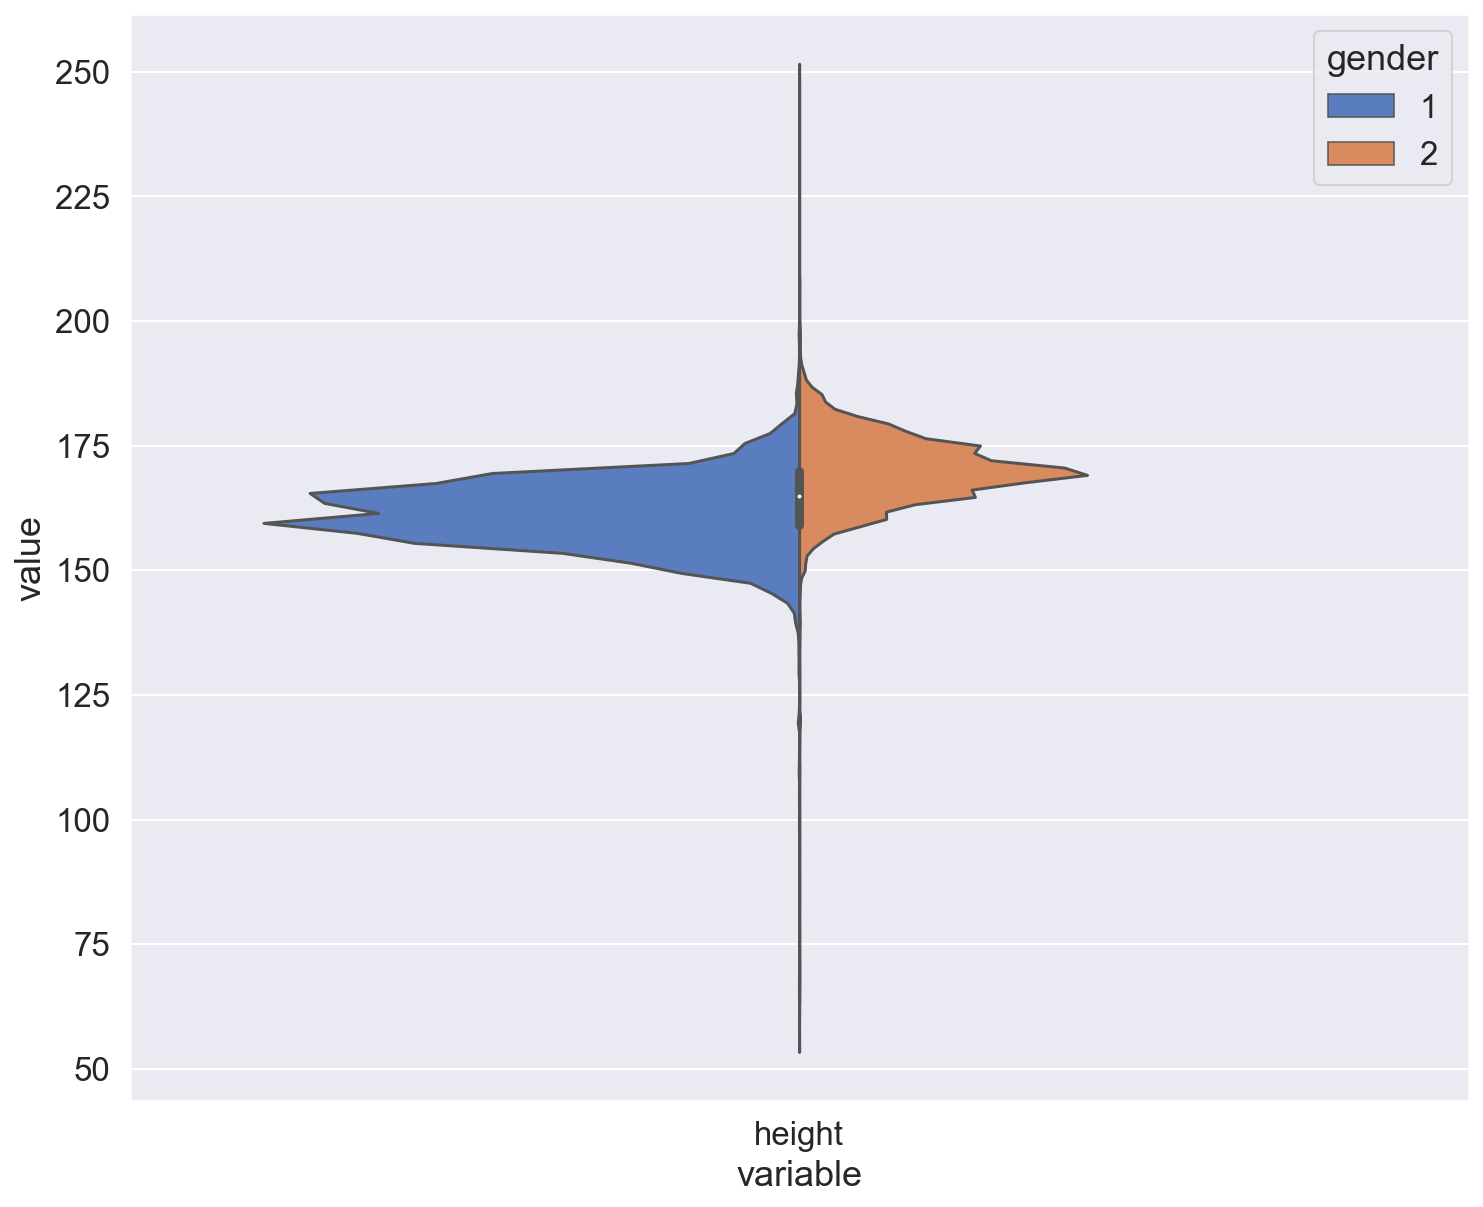

In [40]:
df_melt = pd.melt(frame=df, value_vars=["height"], id_vars=["gender"])

plt.figure(figsize=(12, 10))
ax = sns.violinplot(
    x="variable",
    y="value",
    hue="gender",
    palette="muted",
    split=True,
    data=df_melt,
    scale="count",
    scale_hue=False,
)

In [43]:
df_melt.head()

,gender,variable,value
0,2,height,168
1,1,height,156
2,1,height,165
3,2,height,169
4,1,height,156


Create two kdeplots of the height feature for each gender on the same chart. You will see the difference between the genders more clearly, but you will be unable to evaluate the number of records in each of them.

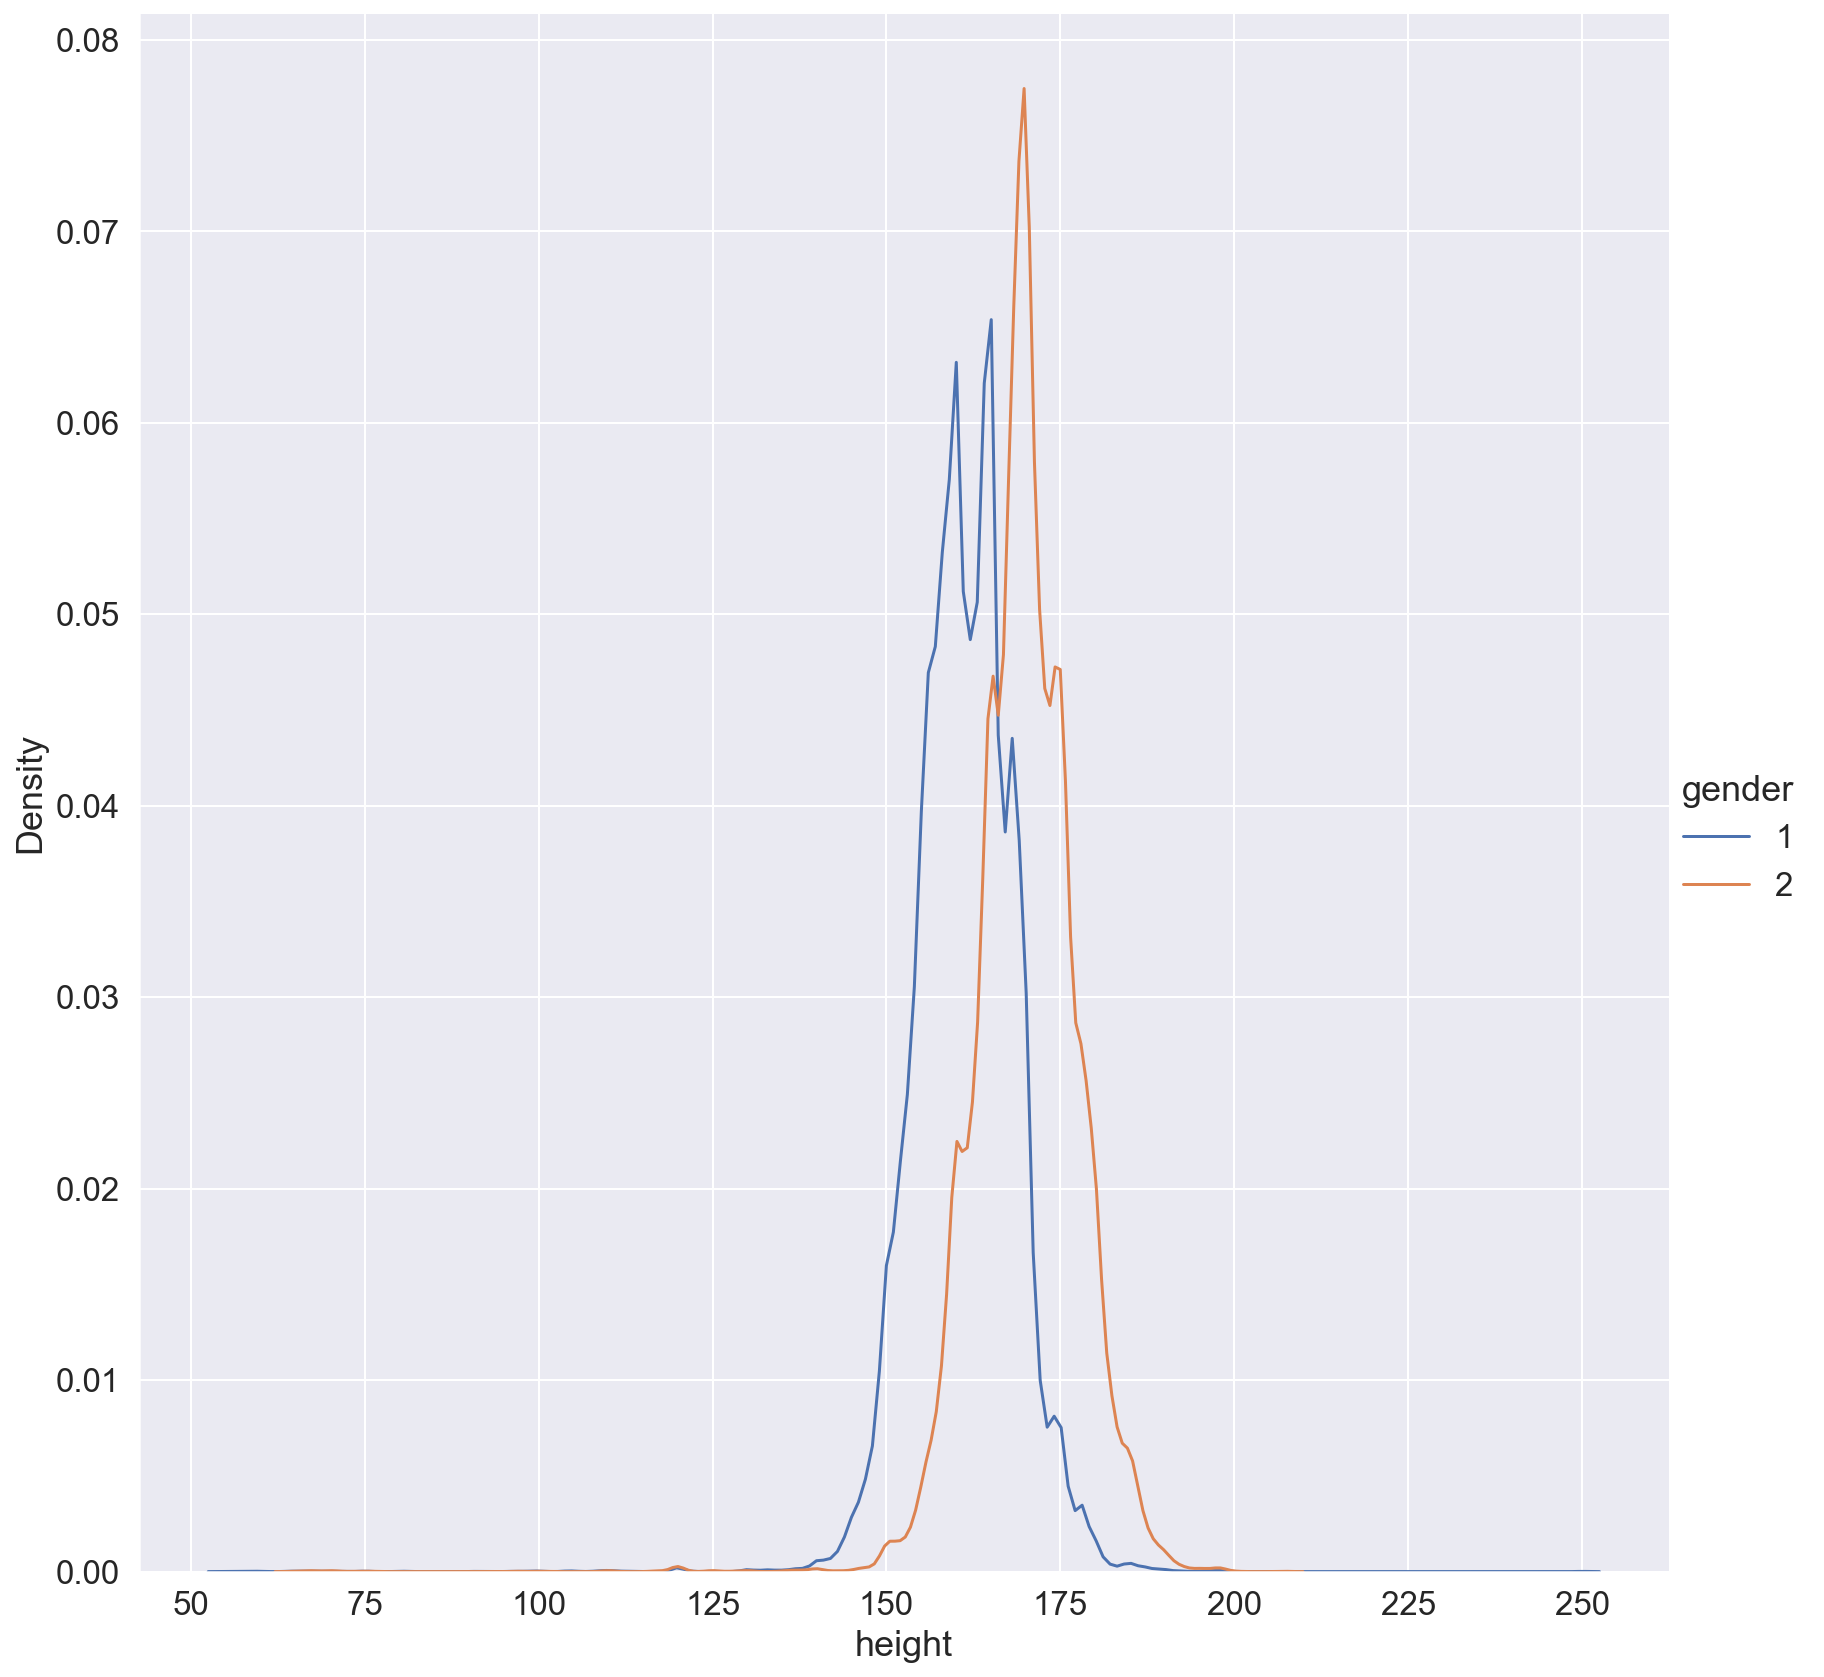

In [41]:
sns.FacetGrid(df, hue="gender", size=12).map(sns.kdeplot, "height").add_legend();

#### Rank correlation

The Pearson coefficient of linear correlation is more than enough to discover patterns in data. 

But let’s calculate a rank correlation. It will help us to identify such feature pairs in which the lower rank in the variational series of one feature always precedes the higher rank in the another one (and we have the opposite in the case of negative correlation).

Calculate and plot a correlation matrix using the Spearman’s rank correlation coefficient.

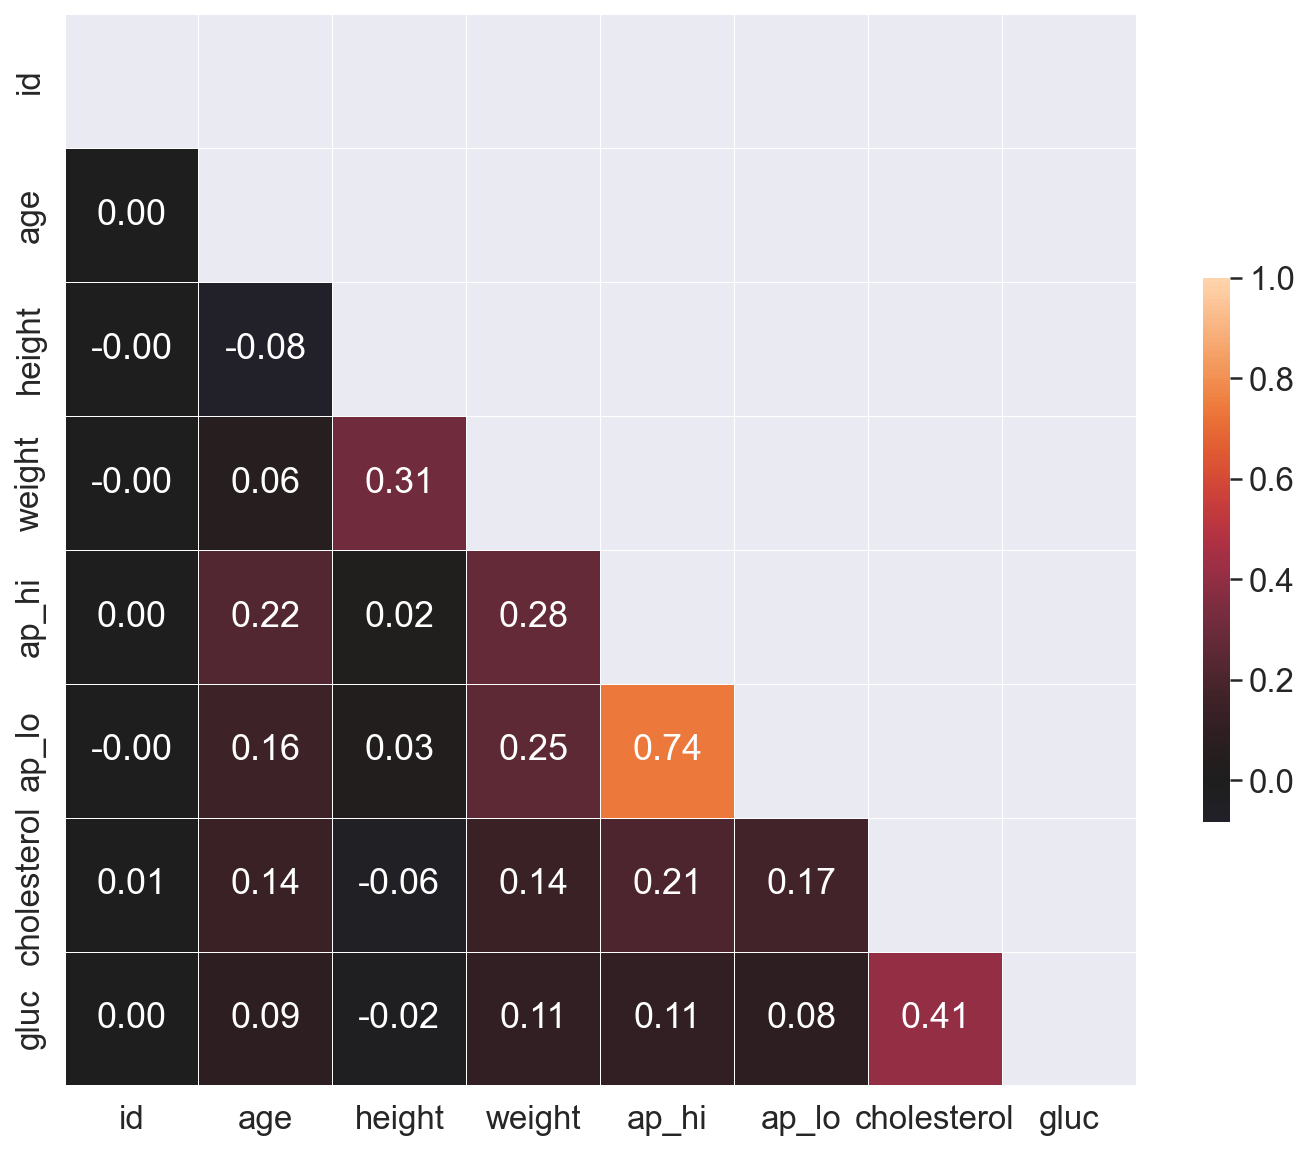

In [44]:
# Calculate the correlation matrix
corr = df[
    ["id", "age", "height", "weight", "ap_hi", "ap_lo", "cholesterol", "gluc"]
].corr(method="spearman")

# Create a mask to hide the upper triangle of the correlation matrix (which is symmetric)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(12, 10))

# Plot the heatmap using the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
);

Which pair of features has the strongest Spearman rank correlation?

* Height, Weight
* Age, Weight
* Cholesterol, Gluc
* Cardio, Cholesterol
* Ap_hi, Ap_lo (0.74)
* Smoke, Alco